In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# Load the data

In [2]:
parse_date = lambda date: pd.datetime.strptime(date, '%Y-%m')
data = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=parse_date)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
data.dtypes

#Passengers    int64
dtype: object

In [4]:
ts = data['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [5]:
from datetime import datetime
ts[datetime(1949,1,1)]

112

/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


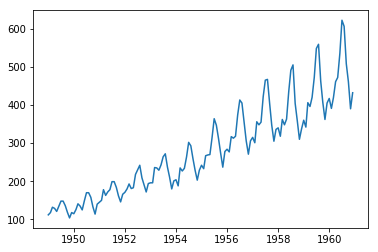

In [6]:
plt.plot(ts)

# Check Stationarity of Time Series

- *Plot Rolling Statistics*: this is just a visual technique
- *Dickey-Fuller Test*: this is a statistical test. Null hypothesis is that the TS is non-stationary. If the test statistic is less than the critical value, we reject the null hypothesis and say that the time series is stationary.

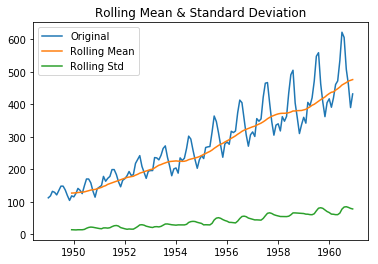

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # calculate rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # plot rolling statistics
    orig = plt.plot(timeseries, color='C0',label='Original')
    mean = plt.plot(rolmean, color='C1', label='Rolling Mean')
    std = plt.plot(rolstd, color='C2', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)

# How to make a Time Series stationary?

- *Trend* – varying mean over time
- *Seasonality* – variations at specific time-frames

## Estimating and Eliminating Trend

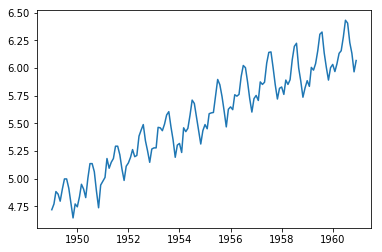

In [8]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [9]:
ts_log_rolling_mean = ts_log.rolling(12).mean()
ts_log_diff = ts_log - ts_log_rolling_mean
ts_log_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

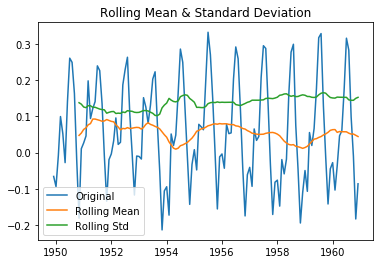

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [10]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

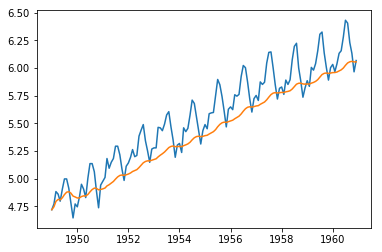

In [11]:
ts_log_ewm = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(ts_log_ewm)

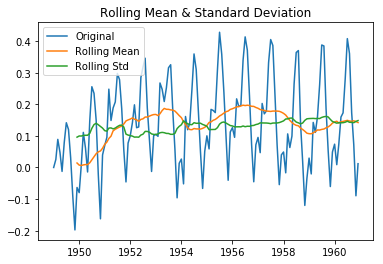

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
ts_log_ewm_diff = ts_log - ts_log_ewm
test_stationarity(ts_log_ewm_diff)

## Eliminating Trend and Seasonality

## Differencing

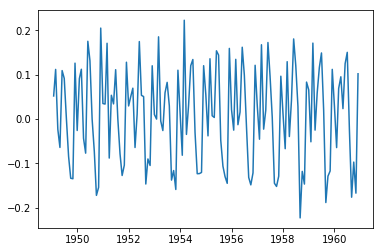

In [13]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

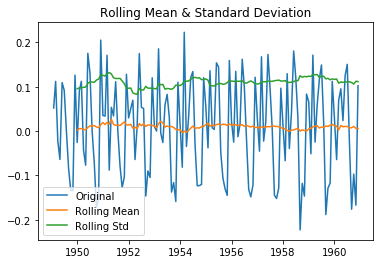

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [14]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## Decomposing

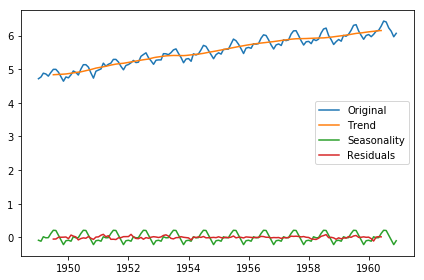

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.plot(ts_log, label='Original')
plt.plot(trend, label='Trend')
plt.plot(seasonal,label='Seasonality')
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

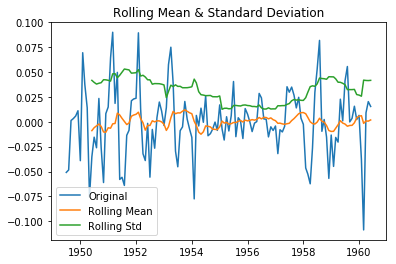

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [16]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Forecasting Time Series

- *ACF* - Autocorrelation Function is a measure of the correlation between the TS with a lagged version of itself.
- *PACF* - Partial Autocorrelation Function measures the correlation between the TS with a lagged version of itself but after eliminating variations already explained by the intervening comparisons.

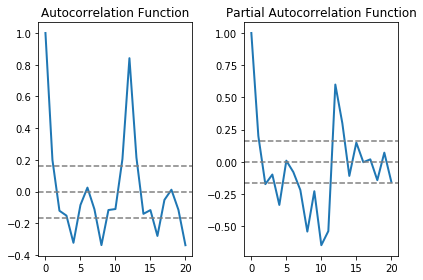

In [17]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags = 20)
lag_pacf = pacf(ts_log_diff, nlags = 20, method= 'ols')

#Plot ACF
plt.subplot(121)
plt.plot(lag_acf, linewidth = 2)
plt.axhline(y = 0, linestyle = '--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function') 

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf, linewidth = 2)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

## AR Model

/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023033685536402')

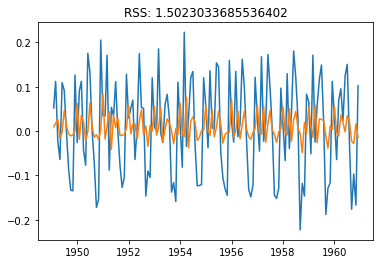

In [18]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues)
plt.title('RSS: {}'.format(sum((results_AR.fittedvalues-ts_log_diff)**2)))

## MA Model

/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721401355870045')

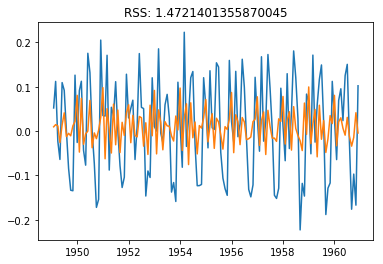

In [19]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues)
plt.title('RSS: {}'.format(sum((results_MA.fittedvalues-ts_log_diff)**2)))

## Combined Model

/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0291520017480527')

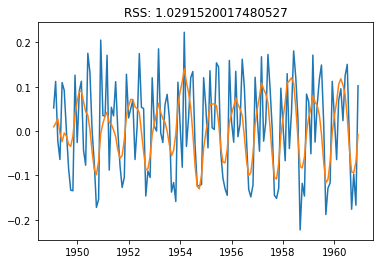

In [20]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues)
plt.title('RSS: {}'.format(sum((results_ARIMA.fittedvalues-ts_log_diff)**2)))

In [21]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

In [22]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [23]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.10462962708655')

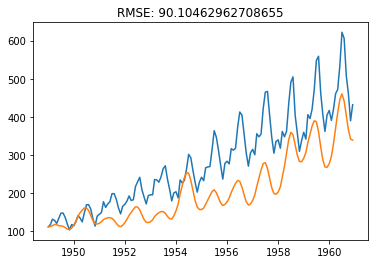

In [24]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: {}'.format(np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts))))

# Predicting 5 years ahead

/Users/pawel/PycharmProjects/data-science/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


<Figure size 936x576 with 0 Axes>

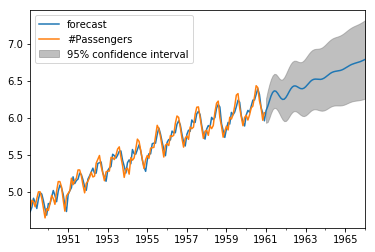

In [25]:
plt.figure(figsize=(13,8))
results_ARIMA.plot_predict(1,204)
plt.legend(loc = 'upper left')
plt.show()